# Model Training
Welcome to the 'Model Training and Prediction' notebook, a crucial facet of our project's data science pipeline. In this notebook, we offer a meticulous examination of our rigorous model development process. The pipeline starts by accepting training data, followed by fitting three distinct types of models to it: Random Forest, Gradient Boosted Tree, and XGBoost. The initial stages include encoding categorical variables and executing Recursive Feature Elimination (RFE) for feature selection. This is succeeded by the application of genetic algorithms to hyperparameter tuning, operating in tandem with a cross-validation routine. Subsequently, the best model is selected based on the highest F1 score, indicating the balance between precision and recall. Finally, the selected model is utilized to predict the outcomes for the current week's round of NRL matches. This process is iterative and cyclical, with the potential for revisiting earlier stages based on the model's performance. Let us proceed with this in-depth exploration.

## Set up Environment
This code segment is setting up the environment for the model training pipeline. It begins by importing sys and pathlib - Python libraries used for managing system parameters and file paths, respectively.

The code then updates the system path to include the "functions" directory. This allows for the import of custom modules `modelling_functions`, `model_properties`, and `training_config` which are stored in this directory. These modules contain custom functions and configuration settings that are critical for the later stages of data preprocessing, model training, and prediction.

Following this, the `project_root` variable is defined. This is achieved by using the pathlib library to establish the root directory of the project.

Finally, the `db_path` variable is constructed. This is the relative path to the SQLite database "footy-tipper-db.sqlite", which is located in the "data" directory of the project root. This path will be used for database connectivity throughout the pipeline.

In [1]:
# import libraries
import os
import sys
import pathlib

cwd = os.getcwd()

# get the parent directory
parent_dir = os.path.dirname(cwd)

# add the parent directory to the system path
sys.path.insert(0, parent_dir)

# Get to the root directory
project_root = pathlib.Path().absolute().parent

# import functions from common like this:
from pipeline.common.model_training import (
    training_config as tc,
    modelling_functions as mf,
    model_properties as mp
)

from pipeline.common.model_prediciton import prediction_functions as pf

## Get data
Our process starts by establishing the root directory of the project and constructing the relative path to the 'footy-tipper-db.sqlite' database located within the 'data' directory. We then connect to this SQLite database and use a SQL query housed in the 'footy_tipping_data.sql' file, found in the 'sql' directory, to extract the required data. This data is loaded into a pandas DataFrame, footy_tipping_data, serving as the basis for our subsequent modeling activities. Upon successful extraction of the data, we ensure the database connection is closed, maintaining good coding practice and resource management.

In [2]:
data = mf.get_training_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/training_data.sql')

data

,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.018111e+10,1.0,Round 1,1.0,Final,1.520540e+09,1.520500e+09,Netstrata Jubilee Stadium,Sydney,14457.0,...,0.0,0.0,1498.872010,1510.437335,-11.565325,0.472175,0.496856,0.030969,-0.024680,2.821392
1,2.018111e+10,1.0,Round 1,2.0,Final,1.520618e+09,1.520579e+09,McDonald Jones Stadium,Newcastle,23516.0,...,0.0,0.0,1484.765189,1496.167714,-11.402525,0.472402,0.496629,0.030969,-0.024227,4.537350
2,2.018111e+10,1.0,Round 1,3.0,Final,1.520622e+09,1.520586e+09,1300SMILES Stadium,Townsville,15900.0,...,0.0,0.0,1506.231994,1503.247565,2.984429,0.492462,0.476569,0.030969,0.015894,2.150093
3,2.018111e+10,1.0,Round 1,4.0,Final,1.520699e+09,1.520660e+09,Accor Stadium,Sydney,18243.0,...,0.0,0.0,1493.847787,1500.971788,-7.124001,0.478367,0.490664,0.030969,-0.012298,-2.314489
4,2.018111e+10,1.0,Round 1,5.0,Final,1.520698e+09,1.520669e+09,Other,Perth,38824.0,...,0.0,0.0,1490.494215,1483.489715,7.004500,0.498066,0.470965,0.030969,0.027100,1.063154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,2.024111e+10,19.0,Round 19,1.0,Final,1.720727e+09,1.720691e+09,Kayo Stadium,Redcliffe,10023.0,...,-16.0,10.0,1496.661993,1497.032388,-0.370395,0.487784,0.481246,0.030969,0.006538,-0.272191
1323,2.024111e+10,19.0,Round 19,2.0,Final,1.720814e+09,1.720778e+09,PointsBet Stadium,Sydney,10912.0,...,34.0,-38.0,1508.922544,1459.452887,49.469657,0.558894,0.413875,0.027231,0.145019,12.820360
1324,2.024111e+10,19.0,Round 19,3.0,Final,1.720892e+09,1.720856e+09,Cbus Super Stadium,Gold Coast,16670.0,...,8.0,52.0,1495.657244,1467.374847,28.282397,0.529663,0.443106,0.027231,0.086557,7.453442
1325,2.024111e+10,19.0,Round 19,4.0,Final,1.720899e+09,1.720863e+09,Suncorp Stadium,Brisbane,34224.0,...,30.0,-38.0,1499.043243,1493.724304,5.318939,0.495717,0.473314,0.030969,0.022402,4.162522


## Modelling

During the modeling phase, the `train_and_select_best_model` function, part of our `modelling_functions` module, is invoked. This function initiates the training of Poisson models specifically designed for predicting the scores of the home and away teams. It takes as input the footy tipping data, predictor variables, the outcome variable, and several configuration settings like whether to use Recursive Feature Elimination (RFE), the number of cross-validation folds, and the optimization metric, all sourced from the `training_config` module.

The function first identifies categorical columns in the feature set for one-hot encoding, creating dummy variables for categorical features. Depending on the choice of using RFE, a feature elimination step may be included in the pipeline. Each model subsequently undergoes hyperparameter tuning using a genetic algorithm, facilitated by the `GASearchCV` function.

All the models are then trained and evaluated through cross-validation. The best models for predicting home and away scores are selected based on superior performance on the chosen optimization metric. The selected models, encapsulated in pipelines with pre-processing steps and hyperparameter tuning, are now ready for the prediction phase.

The trained models are saved using the `save_models` function for future use, ensuring that the prediction process can be efficiently replicated and scaled.

### Test Modelling Data Preparation
First, because we want to understand how effective our simulations are without creating more load on the model cross-validation, we will split the data into training and testing sets. This will allow us to evaluate the model's interaction with each other on unseen data more easily.

In [3]:
# Set the random seed for reproducibility
random_seed = 42

# Define the test size proportion
test_size = 0.2

# Randomly shuffle the DataFrame and split
training_data = data.sample(frac=1 - test_size, random_state=random_seed)
test_data = data.drop(training_data.index)

### Poisson Modelling
The Poisson model is a statistical model that is used to predict the number of events occurring within a fixed interval of time or space. In the context of sports, the Poisson model can be used to predict the number of goals or points scored by each team in a match. In this section, we will implement a Poisson model to predict the number of points scored by each team in a match. We will then use these predictions to calculate the expected match outcome.

#### Home Modelling

In [4]:
home_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_home',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)


Model training: MLPRegressor
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	-42.8039	22.5265    	-10.9562   	-104.956   
1  	134   	-24.6903	15.2743    	-10.779    	-63.8758   
2  	131   	-13.8018	6.25452    	-10.6181   	-45.5044   
3  	143   	-11.1856	0.710364   	-10.0433   	-14.7919   
4  	127   	-10.7784	0.292215   	-10.0433   	-11.5981   
5  	139   	-10.6323	0.257216   	-10.0433   	-11.2439   
6  	142   	-10.5253	0.258954   	-10.0433   	-11.4551   
7  	142   	-10.4206	0.209329   	-10.0058   	-10.7899   
8  	132   	-10.2821	0.201819   	-10.0058   	-11.111    
9  	133   	-10.2131	0.188702   	-10.0058   	-10.9223   
10 	136   	-10.1915	0.193267   	-10.0058   	-11.1357   
11 	147   	-10.2071	0.2925     	-9.8778    	-11.2696   
12 	136   	-10.157 	0.272783   	-9.8778    	-11.2199   
13 	140   	-10.1494	0.28724    	-9.8778    	-11.39     
14 	142   	-10.1356	0.276084   	-9.8778    	-11.3366   
15 	143   	-10.0917	0.240015   	-9.8778    	-11.2035   
16 	145   	-10.105

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=LGBMR...
                                        'num_leaves': <sklearn_genetic.space.space.Integer object at 0x17ffaf110>,
                                        'reg_alpha': <sklearn_genetic.space.space.Continuous object at 0x17ffaf290>,
                                        'reg_lambda': <sklearn_genetic.space.space.Continuous object at 0x17ffae0d0>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x17ffaf7d0>},
                            population_size=100, return_train_score=True,
                            scoring=make_scorer(custom_poisson_deviance, greater_is_better=False)))])

##### Feature Imprtance

In [5]:
preprocessor = home_model.named_steps['one_hot_encoder']
encoded_feature_names = preprocessor.get_feature_names_out(tc.predictors)

# Get the top 20 feature importances
top_20_features = mp.get_feature_importances(home_model, encoded_feature_names)
print(top_20_features)

                                           feature  importance
197                    remainder__season_form_away          17
267         remainder__team_head_to_head_odds_home           6
241                    remainder__season_form_home           6
161                    remainder__line_amount_diff           5
264         remainder__team_head_to_head_odds_away           3
160                      remainder__punt_odds_diff           3
243                 remainder__tries_conceded_home           3
231                 remainder__avg_points_for_home           2
266               remainder__team_line_amount_away           2
220                  remainder__avg_tries_for_away           2
162                    remainder__recent_form_diff           2
167                 remainder__home_loss_rate_home           1
180               remainder__home_ground_advantage           1
102             encoder__team_home_Melbourne Storm           1
165                  remainder__home_win_rate_home     

#### Away Team Modelling

In [6]:
away_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_away',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)


Model training: MLPRegressor
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	-34.6434	19.4793    	-8.75909   	-87.2429   
1  	140   	-19.8752	12.2529    	-8.77205   	-45.9858   
2  	143   	-11.2016	3.84093    	-8.77205   	-34.8051   
3  	129   	-9.43385	0.622379   	-8.63374   	-13.7129   
4  	140   	-9.1277 	0.364768   	-8.52374   	-10.6307   
5  	133   	-8.93385	0.253442   	-8.27052   	-9.51365   
6  	142   	-8.84427	0.256584   	-8.27052   	-9.67065   
7  	145   	-8.74928	0.200406   	-8.27052   	-9.3475    
8  	151   	-8.73517	0.279373   	-8.27052   	-9.8741    
9  	152   	-8.70134	0.269483   	-8.3398    	-9.63526   
10 	152   	-8.67362	0.284061   	-8.39154   	-9.79176   
11 	134   	-8.65163	0.263602   	-8.39154   	-9.54256   
12 	132   	-8.6668 	0.287448   	-8.39154   	-9.60551   
13 	140   	-8.63489	0.305252   	-8.39154   	-9.89338   
14 	136   	-8.59872	0.255797   	-8.39154   	-9.52851   
15 	132   	-8.58066	0.278783   	-8.39052   	-9.78558   
16 	138   	-8.5913

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=LGBMR...
                                        'num_leaves': <sklearn_genetic.space.space.Integer object at 0x1711d91d0>,
                                        'reg_alpha': <sklearn_genetic.space.space.Continuous object at 0x148c0e390>,
                                        'reg_lambda': <sklearn_genetic.space.space.Continuous object at 0x148c0e550>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x1711dad10>},
                            population_size=100, return_train_score=True,
                            scoring=make_scorer(custom_poisson_deviance, greater_is_better=False)))])

##### Feature Importance

In [7]:
# Get the names of the features after preprocessing (one-hot encoding)
preprocessor = away_model.named_steps['one_hot_encoder']
encoded_feature_names = preprocessor.get_feature_names_out(tc.predictors)

# Get the top 20 feature importances
top_20_features = mp.get_feature_importances(away_model, encoded_feature_names)
print(top_20_features)

                                    feature  importance
241             remainder__season_form_home          24
160               remainder__punt_odds_diff          23
197             remainder__season_form_away          23
162             remainder__recent_form_diff          21
180        remainder__home_ground_advantage          17
264  remainder__team_head_to_head_odds_away          17
164             remainder__recent_form_home          16
266        remainder__team_line_amount_away          15
161             remainder__line_amount_diff          12
212          remainder__avg_points_for_away          11
107     encoder__team_home_Penrith Panthers          11
225                     remainder__home_elo          11
234  remainder__competition_point_rate_home          11
213      remainder__avg_points_against_away          10
173      remainder__avg_goals_conceded_home          10
267  remainder__team_head_to_head_odds_home          10
227                remainder__home_elo_prob     

### Example Match Simulation
In this section, we will simulate a match between two teams using the Poisson model. We will generate the expected number of points scored by each team and use these predictions to determine the match outcome. We will then compare the predicted outcome with the actual outcome to evaluate the accuracy of the Poisson model.

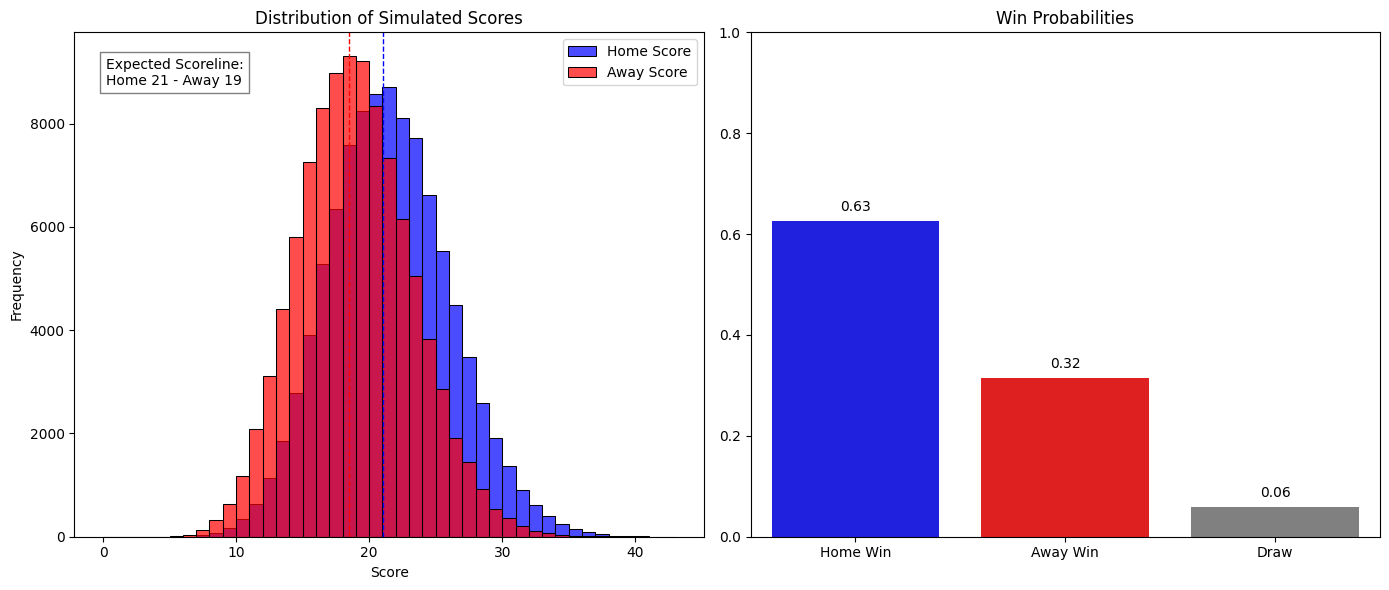

In [8]:
# Example usage with test_data
mp.plot_sampling_distributions(home_model, away_model, test_data, tc.predictors)

###  Evaluation
The evaluation phase involves predicting the outcomes of an unseen set of random NRL matches using the selected home and away models.

This section is only to be used in development and testing at the moment.
#### Classification Report

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

    home_win       0.74      0.85      0.79       150
    away_win       0.76      0.61      0.68       115
        draw       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75       265
   macro avg       0.50      0.49      0.49       265
weighted avg       0.75      0.75      0.74       265



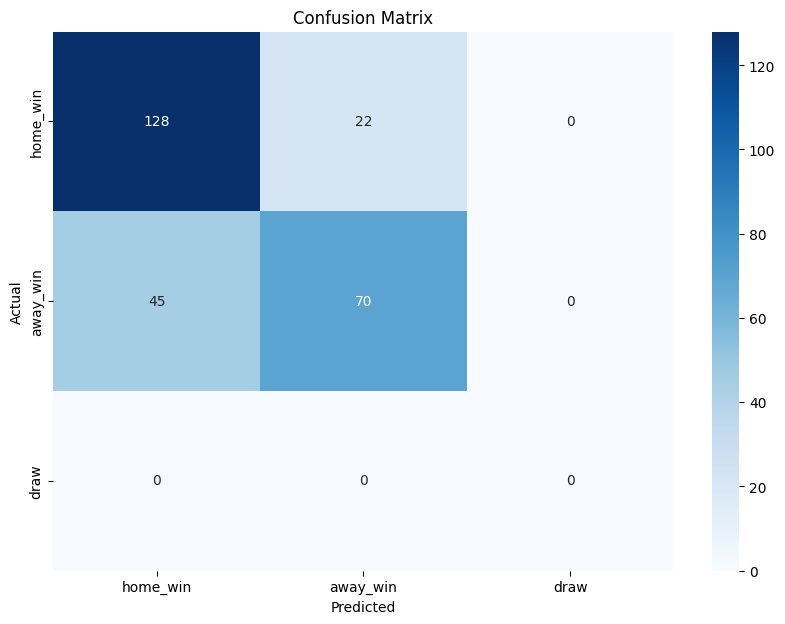

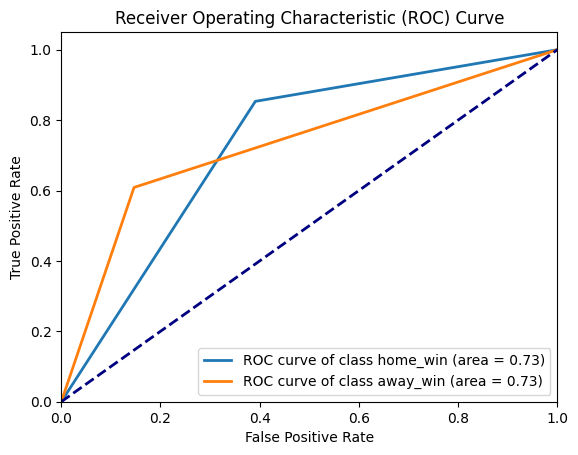

In [9]:
# Evaluate the models on the test data
result_df = mp.evaluate_models(home_model, away_model, test_data, tc.predictors)

#### Expected Scores

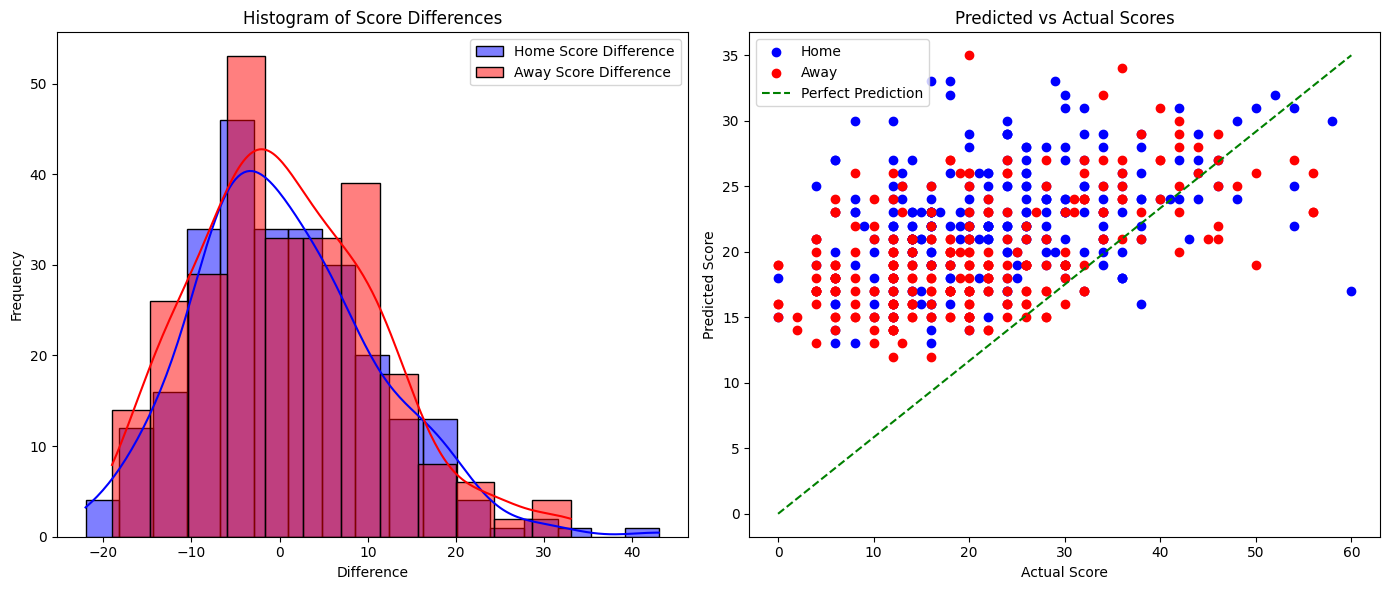

{'mae_home': 8.116981132075471,
 'mae_away': 8.294339622641509,
 'rmse_home': 10.383404756611515,
 'rmse_away': 10.426381633254374,
 'r2_home': 0.1585271737402938,
 'r2_away': 0.24675485107312567}

In [10]:
mp.evaluate_score_predictions(result_df)

## Save Models
The `save_models` function stores Pipeline objects to the disk. This allows for easy retrieval and reuse in future model prediction tasks, without the need to retrain these components. The objects are stored in a designated 'models' directory under the project root path, ensuring organized and consistent storage.

In [11]:
mf.save_models(home_model, 'home_model', project_root)
mf.save_models(away_model, 'away_model', project_root)

Pipeline saved to models/home_model.pkl
Pipeline saved to models/away_model.pkl


## Match Simulation and Prediction
The final stage of the pipeline involves predicting the outcomes of the current week's NRL matches. This is achieved by loading the saved models from the 'models' directory and utilizing them to simulate the matches. The predictions are then stored in a DataFrame, which is subsequently written back to the SQLite database. This data can be accessed by the front-end application to display the predicted outcomes to the users.

In [12]:
# Load the models
home_model = pf.load_models('home_model', project_root)
away_model = pf.load_models('away_model', project_root)

# Load this week's game data
inference_data = pf.get_inference_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/inference_data.sql')
inference_data

home_model model pipeline loaded
away_model model pipeline loaded
Getting inference data...


,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.024111e+10,20.0,Round 20,1.0,Pre Game,1.721419e+09,1.721383e+09,GIO Stadium,Canberra,None,...,1.0,-5.0,1466.742144,1490.804290,-24.062145,0.453863,0.513208,0.032929,-0.059345,1.344333
1,2.024111e+10,20.0,Round 20,2.0,Pre Game,1.721488e+09,1.721452e+09,Industree Group Stadium,Gosford,None,...,52.0,-38.0,1493.768531,1441.920648,51.847883,0.567919,0.414840,0.017241,0.153079,10.441167
2,2.024111e+10,20.0,Round 20,3.0,Pre Game,1.721497e+09,1.721461e+09,McDonald Jones Stadium,Newcastle,None,...,16.0,-8.0,1476.159867,1496.484108,-20.324241,0.459049,0.508022,0.032929,-0.048974,0.119033
3,2.024111e+10,20.0,Round 20,4.0,Pre Game,1.721504e+09,1.721468e+09,AAMI Park,Melbourne,None,...,-10.0,20.0,1526.670571,1559.707999,-33.037428,0.441441,0.525630,0.032929,-0.084189,4.270667
4,2.024111e+10,20.0,Round 20,5.0,Pre Game,1.721570e+09,1.721534e+09,BlueBet Stadium,Penrith,None,...,20.0,-30.0,1529.179128,1499.925850,29.253279,0.531011,0.441758,0.027231,0.089254,12.879433
5,2.024111e+10,20.0,Round 20,6.0,Pre Game,1.721578e+09,1.721542e+09,4 Pines Park,Sydney,None,...,-4.0,42.0,1521.779247,1496.042928,25.736320,0.526125,0.446644,0.027231,0.079481,7.557700
6,2.024111e+10,20.0,Round 20,7.0,Pre Game,1.721586e+09,1.721550e+09,Queensland Country Bank Stadium,Townsville,None,...,18.0,-19.0,1501.841680,1509.245624,-7.403943,0.477976,0.491055,0.030969,-0.013078,4.347300


### Prediction Simulation
The `simulate_predictions` function is used to predict the outcomes of the current week's NRL matches. It loads the saved models from the 'models' directory and uses them to simulate the matches. The predictions are then stored in a DataFrame, which is written back to the SQLite database.

In [13]:
import pandas as pd

# Predict match outcomes and scorelines for the inference data
outcomes, margins = pf.predict_match_outcome_and_scoreline(home_model, away_model, inference_data, tc.predictors)
pd.merge(outcomes, margins, on='game_id')

# Save the predictions to the database
pf.save_predictions_to_db(
    outcomes, 
    project_root / "data" / "footy-tipper-db.sqlite", 
    project_root / 'pipeline/common/sql/create_table.sql', 
    project_root / 'pipeline/common/sql/insert_into_table.sql'
)

Saving predictions to database...


## Sending Predictions via Email using ChatGPT
In this section, we will use the OpenAI ChatGPT model to generate an email template for sending the predictions to the users. We will use the predictions generated in the previous section and the ChatGPT model to create a personalized email template for each user. The email template will contain the predicted outcomes of the NRL matches for the current week.

In [14]:
from dotenv import load_dotenv
from pipeline.common.model_prediciton import prediction_functions as pf
from pipeline.common.use_predictions import sending_functions as sf

# Now construct the relative path to your SQLite database
db_path = project_root / "data" / "footy-tipper-db.sqlite"
secrets_path = project_root / "secrets.env"
json_path = project_root / "service-account-token.json"

load_dotenv(dotenv_path=secrets_path)

True

In [15]:
import sqlite3
import pandas as pd
# Connect to the SQLite database
con = sqlite3.connect(str(db_path))

# Read SQL query from external SQL file
with open(project_root / 'pipeline/common' / 'sql/prediction_table.sql', 'r') as file:
    query = file.read()

# Execute the query and fetch the results into a data frame
predictions = pd.read_sql_query(query, con)

# Disconnect from the SQLite database
con.close()

predictions

,game_id,home_team_result,team_home,position_home,team_head_to_head_odds_home,team_away,position_away,team_head_to_head_odds_away,home_team_win_prob,home_team_lose_prob,round_id,competition_year,round_name
0,20241112010,Win,Canberra Raiders,11,1.69,New Zealand Warriors,12,2.18,0.63397,0.31179,20,2024,Round 20
1,20241112020,Win,South Sydney Rabbitohs,15,1.32,Wests Tigers,17,3.41,0.97183,0.01972,20,2024,Round 20
2,20241112030,Win,Newcastle Knights,10,2.36,Brisbane Broncos,13,1.60,0.65957,0.28597,20,2024,Round 20
3,20241112040,Win,Melbourne Storm,1,2.10,Sydney Roosters,3,1.75,0.58419,0.35742,20,2024,Round 20
4,20241112050,Win,Penrith Panthers,2,1.21,Dolphins,6,4.45,0.94976,0.03564,20,2024,Round 20
5,20241112060,Win,Manly-Warringah Sea Eagles,7,1.45,Gold Coast Titans,14,2.78,0.86412,0.10686,20,2024,Round 20
6,20241112070,Win,North Queensland Cowboys,8,1.69,Canterbury-Bankstown Bulldogs,5,2.17,0.73123,0.22113,20,2024,Round 20


### Tippper Picks
The Tipper Picks are selcted games which show high value for the tipper to select. This is based on the predicted outcomes of the matches and the odds of the games.

This shows how predictions can be used to further enrich the user experience and provide valuable insights to the users.

In [16]:
tipper_picks = sf.get_tipper_picks(predictions)
tipper_picks

,team,price,price_min
0,Canberra Raiders,1.69,1.577362
1,South Sydney Rabbitohs,1.32,1.028987
2,Newcastle Knights,2.36,1.516139
3,Melbourne Storm,2.10,1.711772
4,Penrith Panthers,1.21,1.052898
5,Manly-Warringah Sea Eagles,1.45,1.157247
6,North Queensland Cowboys,1.69,1.367559


In [17]:
# sf.upload_df_to_drive(
#     predictions, 
#     json_path, 
#     os.getenv('FOLDER_ID'), 
#     "predictions.csv"
# )

### Reg Reagan's Email
In this section, we will generate an email from Reg Reagan, a fictional character, using the OpenAI ChatGPT model. The email will contain the predicted outcomes of the NRL matches for the current week, along with some humorous and engaging content. The email will be sent to the users to provide them with the predictions and entertain them at the same time.

In [18]:
reg_reagan = sf.generate_reg_regan_email(
    predictions, 
    tipper_picks, 
    os.getenv('OPENAI_KEY'), 
    os.getenv('FOLDER_URL'),
    1
)

print(reg_reagan)

Subject: Punting Predictions Guaranteed *Draws* for Fans Who Dare!

Hey Lads,

In our unrelenting endeavor to be the wind beneath your wings during this crazy NRL season, Reg Reagan has done it again! Thanks to our latest AI prodigy, the Footy Tipper, we've got some juicy predictions that could set you on the path to glory. Let’s dive in, shall we?

First, we got our bandicoots, the Canberra Raiders with a prime spot at the 11th Position, showing the New Zealand Warriors what's what. The footy tipper predicts a glorious home win for the Raiders, at a dashing price of 1.69. Sure it’s near the bottom of the ladder, but who doesn’t love an underdog story?

Next up, the South Sydney Rabbitohs vs Wests Tigers in a showdown that couldn't be more uneven if they tried. Here you got the Rabbitohs, languishing at lucky number 15, and yet the Footy Tipper's money is on them. Price's a bit rich at 1.32, but hell, they're practically playing against kittens. 

Now, if you're looking for something a

In [19]:
# sf.send_emails(
#     "footy-tipper-email-list", 
#     f"Footy Tipper Predictions for {predictions['round_name'].unique()[0]}", 
#     reg_reagan, 
#     os.getenv('MY_EMAIL'), 
#     os.getenv('EMAIL_PASSWORD'), 
#     json_path
# )